# Example: mesh a delineated watershed

Here we mesh the [Coweeta Hydrologic Laboratory](https://www.srs.fs.usda.gov/coweeta/) as an example of how to pull data in from default locations and generate a fully functional ATS mesh.

This might be the worst example to use to learn how to use Watershed Workflows.  But it is useful to demonstrate the breadth of problems this project was intended to solve.

This includes a range of datasets:

* NHD Plus for river network
* NRCS soils data for soil types
* NLCD for land cover/transpiration/rooting depths
* NED for elevation

In [1]:
%matplotlib inline
# %matplotlib notebook

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [2]:
import sys
sys.path.append("./")
# sys.path.append("/Users/shua784/Dropbox/github/watershed-workflow")
# sys.path.append("/Users/shua784/Dropbox/github/watershed-workflow/workflow_tpls")
# sys.path.append("/Users/shua784/Dropbox/github/watershed-workflow/workflow")
sys.path.append("/Users/shua784/Dropbox/github/seacas/install/lib")

sys.path.append("../../watershed-workflow")
sys.path.append("../workflow_tpls")
sys.path.append("../workflow")

In [3]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
from matplotlib_scalebar.scalebar import ScaleBar
import shapely
import logging
import fiona
import rasterio
import pickle

import workflow
import workflow.source_list
import workflow.ui
import workflow.colors
import workflow.condition
import workflow.mesh
import workflow.split_hucs

workflow.ui.setup_logging(1,None)
figsize = (6,6)
figsize_3d = (8,6)

In [4]:
def doArraysIntersect(array1, array2):
    return bool(set(array1) & set(array2))

In [5]:
watershed_name = "CoalCreek"
fname_surface_mesh = "./meshes/{}_surface_mesh.vtk".format(watershed_name)
fname_final_mesh = "./meshes/{}_final_mesh.exo".format(watershed_name)

fig_mesh = "./figures/{}_mesh.png".format(watershed_name)
fig_mesh3D = "./figures/{}_mesh3D.png".format(watershed_name)
fig_soil_type = "./figures/{}_soil_type.png".format(watershed_name)
fig_geol_map = "./figures/{}_geol_map.png".format(watershed_name)
fig_land_cover = "./figures/{}_land_cover.png".format(watershed_name)
fig_hru = "./figures/{}_HRU.png".format(watershed_name)
fig_DTB = "./figures/{}_DTB.png".format(watershed_name)

fname_mesh_pickle = f'./results/{watershed_name}_mesh.p'
fname_soil_id = f'./results/{watershed_name}_soil_id.txt'
fname_geol_id = f'./results/{watershed_name}_geol_id.txt'

In [50]:
# specify the input shapefile and a hint as to what HUC it is in.
# watershed_shapefile = '../data/hydrologic_units/yakima/yakima_EPSG4269.shp'
watershed_shapefile = '../data/hydrologic_units/EastTaylor/CoalCreek.shp'
# watershed_shapefile = '../data/hydrologic_units/yakima/UpperYakima_EPSG4269c.shp'

# river_shp = "../data/hydrologic_units/yakima/yakima_river_network.shp"

# fname_hru = "../data/hydrologic_units/Maumee/EC_HRU_reproj.shp"
# fname_soil = "../data/soil/yakima/ssurgo_yakima.shp"
fname_dem = "/Users/shua784/OneDrive - PNNL/Projects/Exasheds/Upper_Colorado_River_Basin/GIS/EastTaylor_DEM/GreaterEastTayor_dem_10m.tif"
fname_soil = "/Users/shua784/OneDrive - PNNL/Projects/Exasheds/Upper_Colorado_River_Basin/GIS/gNATSGO/gNATSGO_CO_raster/MapunitRaster_10m1.tif"
fname_DTB = "/Users/shua784/OneDrive - PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/depth-to-bedrock/Global_absoluteDTB_M_250m_ll.tif"
fname_geology = "/Users/shua784/OneDrive - PNNL/Projects/Exasheds/Upper_Colorado_River_Basin/GIS/EastTaylor_GLHYMPS/EastTaylor_GLHYMPS_v2.shp"

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [14]:
# hint = '0410'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape


logging.info("")
logging.info("Meshing shape: {}".format(watershed_shapefile))
logging.info("="*30)

# get the shape and crs of the shape
crs, watershed = workflow.get_split_form_shapes(watershed_shapefile)
logging.info("watershed CRS: {}".format(crs))

2020-11-09 16:51:11,166 - root - INFO: 
2020-11-09 16:51:11,167 - root - INFO: Meshing shape: ../data/hydrologic_units/EastTaylor/CoalCreek.shp
2020-11-09 16:51:11,168 - root - INFO: ==============================
2020-11-09 16:51:11,169 - root - INFO: 
2020-11-09 16:51:11,169 - root - INFO: Preprocessing Shapes
2020-11-09 16:51:11,169 - root - INFO: ------------------------------
2020-11-09 16:51:11,170 - root - INFO: loading file: "../data/hydrologic_units/EastTaylor/CoalCreek.shp"
/opt/anaconda3/envs/watershed_workflow/lib/python3.8/site-packages/fiona/collection.py:352: FionaDeprecationWarning: Collection slicing is deprecated and will be disabled in a future version.
  return self.session.__getitem__(item)
2020-11-09 16:51:11,184 - root - INFO: watershed CRS: EPSG:26913


A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [15]:
# set up a dictionary of source objects
sources = workflow.source_list.get_default_sources()
# use 10-m DEM instead
# sources['DEM'] = workflow.source_list.dem_sources['NED 1/3 arc-second']
workflow.source_list.log_sources(sources)

2020-11-09 16:51:14,811 - root - INFO: Using sources:
2020-11-09 16:51:14,811 - root - INFO: --------------
2020-11-09 16:51:14,812 - root - INFO: HUC: National Watershed Boundary Dataset (WBD)
2020-11-09 16:51:14,812 - root - INFO: hydrography: National Hydrography Dataset (NHD)
2020-11-09 16:51:14,813 - root - INFO: DEM: National Elevation Dataset (NED); resolution: 1 arc-second
2020-11-09 16:51:14,814 - root - INFO: soil type: National Resources Conservation Service Soil Survey (NRCS Soils)
2020-11-09 16:51:14,814 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2020-11-09 16:51:14,814 - root - INFO: soil thickness: None
2020-11-09 16:51:14,815 - root - INFO: meteorology: DayMet 1km


## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

## import river shapes

### option1 -- import river shapes

In [94]:
# with fiona.open(river_shp, mode='r') as fid:
#     profile = fid.profile
#     reaches = [r for (i,r) in fid.items()]

Watershed boundary and river must be in the same CRS.

In [8]:
# # convert to destination crs
# native_crs = workflow.crs.from_fiona(profile['crs'])
# if crs and not workflow.crs.equal(crs, native_crs):
#     for reach in reaches:
#         workflow.warp.shape(reach, native_crs, crs)
# else:
#     crs = native_crs

**convert to shapely, and merge multiple reach segments into single rivers**

In [ ]:
# reaches_s = [workflow.utils.shply(reach) for reach in reaches]
# # rivers_s = list([shapely.ops.linemerge(shapely.geometry.MultiLineString(reaches_s))])

# rivers = workflow.simplify_and_prune(watershed, reaches_s, filter=False, simplify=30, cut_intersections=False)

In [ ]:
# logging.info("Generate the river tree")
# rivers = workflow.hydrography.make_global_tree(rivers_s)

### Option 2--download river hydrography from NHD

In [ ]:
# # find what HUC our shape is in
# huc = workflow.find_huc(sources['HUC'], watershed.exterior(), crs, hint = '1703', shrink_factor=0.1)
# logging.info("Found watershed in HUC: {}".format(huc))

In [24]:
# sources['hydrography'] = workflow.source_list.hydrography_sources['NHD Plus']

In [16]:
huc = "140200010204" # provide the HUC8/HUC12 for NHD or HUC4 for NHDPlus that includes that watershed
simplify = 30 # length scale to target average edge

rivers = True
if rivers:
    # download/collect the river network within that shape's bounds
    _, reaches = workflow.get_reaches(sources['hydrography'], huc, 
                                      watershed.exterior().bounds, crs,
                                     cvrt = True)
    # simplify and prune rivers not IN the shape, constructing a tree-like data structure
    # for the river network
    rivers = workflow.simplify_and_prune(watershed, reaches, filter=True, simplify=simplify, cut_intersections=True)

else:
    rivers = list()
    workflow.split_hucs.simplify(watershed, simplify)



2020-11-09 16:51:20,304 - root - INFO: 
2020-11-09 16:51:20,304 - root - INFO: Preprocessing Hydrography
2020-11-09 16:51:20,305 - root - INFO: ------------------------------
2020-11-09 16:51:20,305 - root - INFO: Loading streams in HUC 140200010204
2020-11-09 16:51:20,306 - root - INFO:          and/or bounds (317251.2640131897, 4299711.408984916, 328473.7039815487, 4307062.45088187)
2020-11-09 16:51:20,308 - root - INFO: Using Hydrography file "/Users/shua784/OneDrive - PNNL/github/watershed-workflow/examples/data/hydrography/NHD_H_14020001_GDB/NHD_H_14020001.gdb"
2020-11-09 16:51:20,572 - root - INFO:   found 176 reaches
2020-11-09 16:51:20,573 - root - INFO: convert to destination crs : EPSG:26913
2020-11-09 16:51:42,069 - root - INFO: out crs: EPSG:26913
2020-11-09 16:51:42,069 - root - INFO: convert to 176 shapely files
2020-11-09 16:51:42,084 - root - INFO: merge all shapely branched lines into a single line
2020-11-09 16:51:42,088 - root - INFO: 
2020-11-09 16:51:42,089 - root 

### plot watershed bnd and river networks

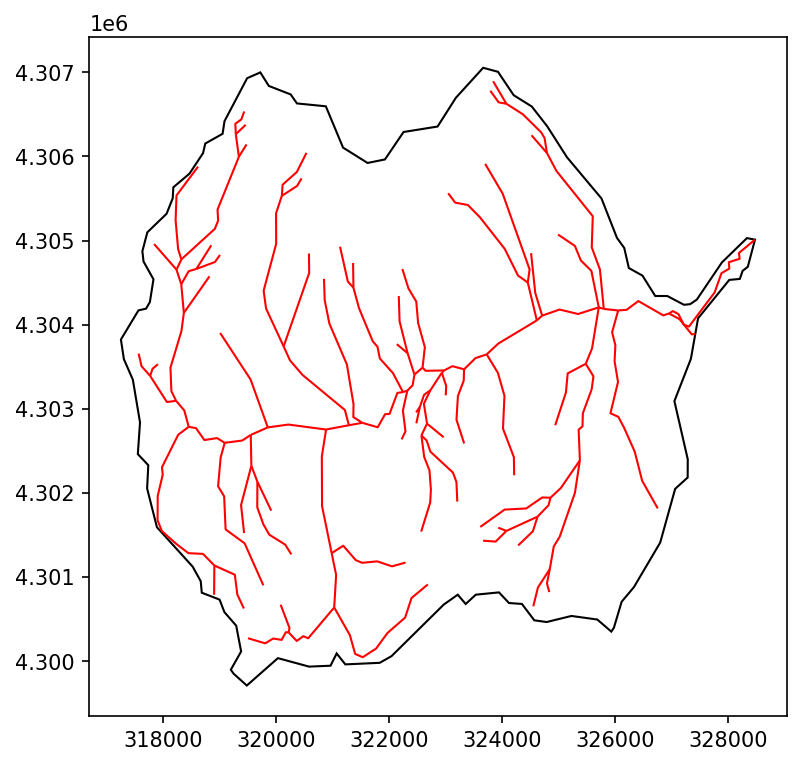

In [17]:
# plot what we have so far -- an image of the HUC and its stream network
fig,ax = plt.subplots(1,1, figsize=(6,6))
# ax = workflow.plot.get_ax(crs, fig)

workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)

plt.show()

2020-11-09 16:51:42,791 - root - INFO: 
2020-11-09 16:51:42,792 - root - INFO: Meshing
2020-11-09 16:51:42,793 - root - INFO: ------------------------------
2020-11-09 16:51:42,794 - root - INFO: Triangulating...
2020-11-09 16:51:42,803 - root - INFO:    393 points and 394 facets
2020-11-09 16:51:42,804 - root - INFO:  checking graph consistency
2020-11-09 16:51:42,804 - root - INFO:  tolerance is set to 1
2020-11-09 16:51:42,808 - root - INFO:  building graph data structures
2020-11-09 16:51:42,812 - root - INFO:  triangle.build...
2020-11-09 16:51:42,812 - root - WARNING: Triangulate: '--enforce-delaunay' option requires a hacked `meshpy.triangle`.  Proceeding without this option because it is not recognized.
2020-11-09 16:51:47,749 - root - INFO:   ...built: 3531 mesh points and 6825 triangles
2020-11-09 16:51:47,750 - root - INFO: Plotting triangulation diagnostics
2020-11-09 16:51:48,591 - root - INFO:   min area = 0.224609375
2020-11-09 16:51:48,593 - root - INFO:   max area = 98

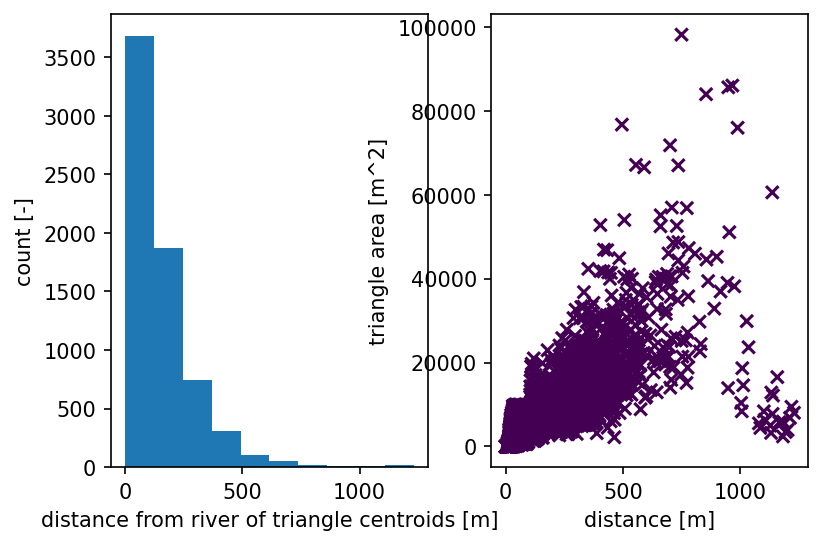

In [18]:
# form a triangulation on the shape + river network

# triangulation refinement:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the 
# distance from the triangle centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and
# linearly interpolates between the two endpoints.
d0 = 100; d1 = 500
# A0 = 1000; A1 = 5000 # [40, 100]m
A0 = 10000; A1 = 500000 # [100, 1000]m
#A0 = 100; A1 = 500

# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
mesh_points2, mesh_tris, d = workflow.triangulate(watershed, rivers, 
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               enforce_delaunay=True,
                                               diagnostics=True)
#mesh_points2, mesh_tris, d = workflow.triangulate(watershed, rivers,
#                                                 refine_max_area=100000,
#                                                 enforce_delaunay=True,
#                                                 diagnostics=True)

## Download DEM

If mannually importing DEM, make sure the DEM map is slightly larger than the watershed boundary. Otherwise, artificial values may occur at the watershed boundary.

In [24]:
logging.info("import dem from {}".format(fname_dem))
with rasterio.open(fname_dem, 'r') as fid:
    dem_profile = fid.profile
    dem = fid.read(1) # read the first band

2020-11-09 16:58:49,173 - root - INFO: import dem from /Users/shua784/OneDrive - PNNL/Projects/Exasheds/Upper_Colorado_River_Basin/GIS/EastTaylor_DEM/GreaterEastTayor_dem_10m.tif


In [ ]:
# # get a raster for the elevation map, based on NED
# dem_profile, dem = workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)

### Map mesh to DEM

In [91]:
# # resample the raster to the triangles
# DEM_mesh = workflow.values_from_raster(m2.centroids(), crs, dem, dem_profile)

In [25]:
# elevate the triangle nodes to the dem
mesh_points3 = workflow.elevate(mesh_points2, crs, dem, dem_profile)

2020-11-09 16:58:55,017 - root - INFO: 
2020-11-09 16:58:55,019 - root - INFO: Elevating Triangulation to DEM
2020-11-09 16:58:55,019 - root - INFO: ------------------------------


Plotting the resulting mesh can be done in a variety of ways, including both 3D plots and mapview.  We show both here, but hereafter use mapview plots as they are a bit clearer (if not so flashy)...

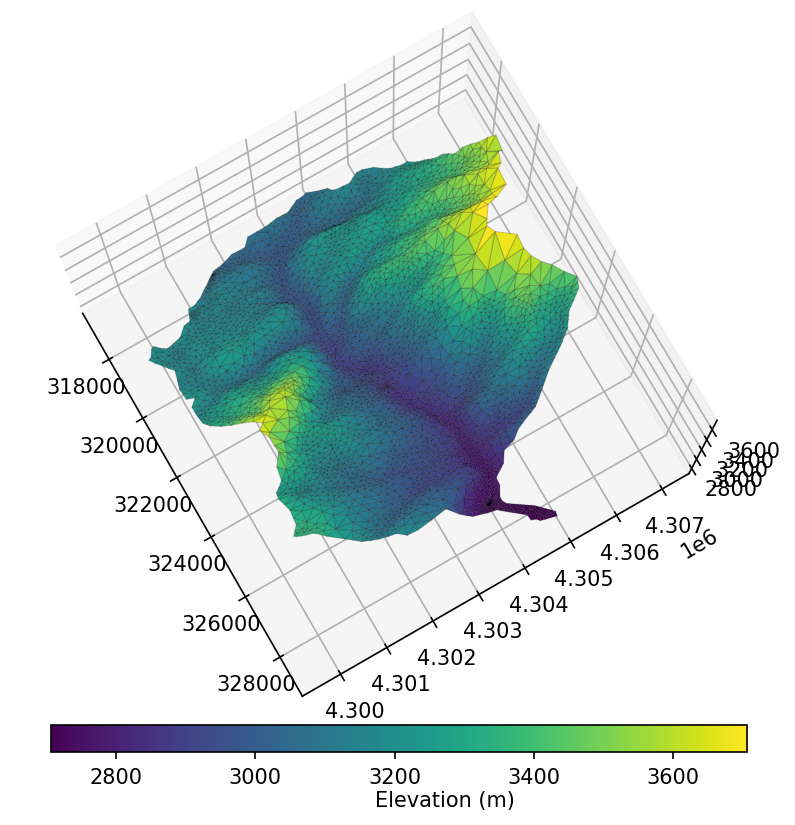

In [26]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize_3d)
ax = workflow.plot.get_ax('3d', fig, window=[0.0,0.2,1,0.8])
cax = fig.add_axes([0.23,0.18,0.58,0.03])

mp = ax.plot_trisurf(mesh_points3[:,0], mesh_points3[:,1], mesh_points3[:,2], 
                     triangles=mesh_tris, cmap='viridis', 
                     edgecolor=(0,0,0,.2), linewidth=0.5)
cb = fig.colorbar(mp, orientation="horizontal", cax=cax)

# t = cax.set_title('elevation [m]')
plt.text(0.5, -0.1, 'Elevation (m)', transform=ax.transAxes)

ax.view_init(80,-30)
# ax.set_xticklabels(list())
# ax.set_yticklabels(list())

fig.savefig(fig_mesh3D, dpi = 300, transparent= True)

(316690.15495, 329034.55405000004)
(4299344.330884162, 4307420.049100754)


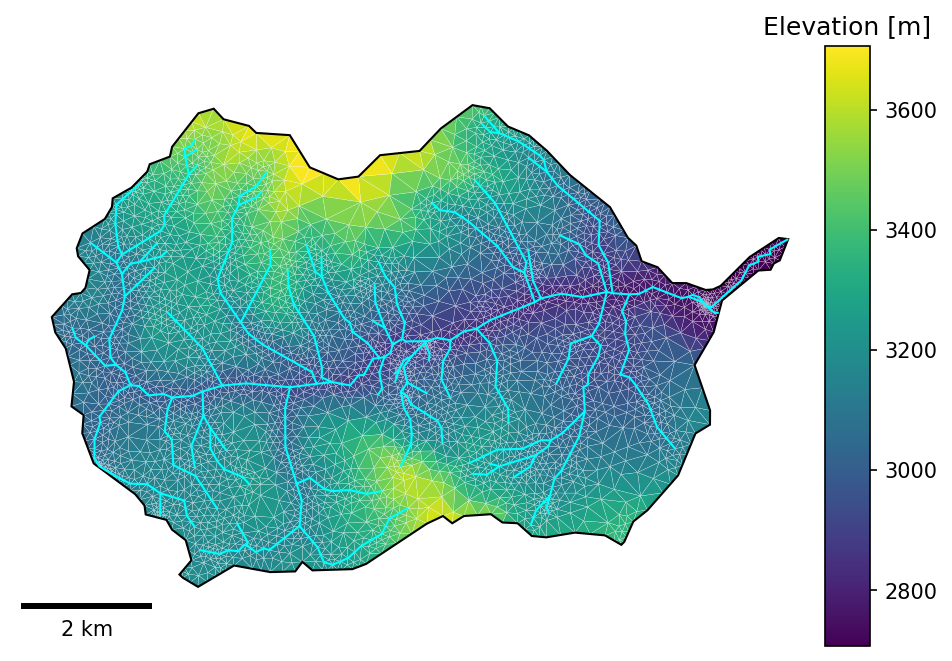

In [27]:
# plot the resulting surface mesh
fig = plt.figure(figsize=(6,5))
ax = workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
#ax2 = workflow.plot.get_ax(crs,fig, window=[0.65,0.05,0.3,0.5])
# ax2 = ax.inset_axes([0.58,0.45,0.3,0.3])
# cbax = fig.add_axes([0.05,0.05,0.9,0.05])
cbax = fig.add_axes([.95,0.1,0.05,0.8])

bxlim = (591000., 600000.)
bylim = (94000., 103000.)

mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color='elevation', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='aqua', linewidth=1)
ax.set_aspect('equal', 'datalim')
# ax.set_xlim([770000, 800000])
# ax.set_ylim([4520000, 4550000])

# mp2 = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
#                                  color='elevation', edgecolor='white', linewidth=0.5)
# workflow.plot.hucs(watershed, crs, ax=ax2, color='k', linewidth=1)
# workflow.plot.rivers(rivers, crs, ax=ax2, color='aqua', linewidth=1.5)
# ax2.set_xlim(bxlim)
# ax2.set_ylim(bylim)
# ax2.set_xticks([])
# ax2.set_yticks([])
# ax2.set_aspect('equal', 'datalim')

# ax.indicate_inset_zoom(ax2, edgecolor='r')

# ax.margins(0.5)
ax.axis('off')
# add scalebar, use 1 for UTM coordinates, the default unit is "m"
scalebar1 = ScaleBar(1, location = "lower left")
ax.add_artist(scalebar1)
# scalebar2 = ScaleBar(1, location = "upper right")

# ax2.add_artist(scalebar2)

print(ax.get_xlim())
print(ax.get_ylim())
cbar.ax.set_title('Elevation [m]')

# fig.tight_layout()
fig.savefig(fig_mesh, dpi = 300, transparent = True)

In [28]:
with open(fname_mesh_pickle, 'wb') as f:
    pickle.dump((mesh_points3, mesh_points2, mesh_tris), f, protocol=-1)

### construct 2d mesh 

In [11]:
with open(fname_mesh_pickle, 'rb') as f:
    mesh_points3, mesh_points2, mesh_tris = pickle.load(f)

In [29]:
# construct the 2D mesh
m2 = workflow.mesh.Mesh2D(mesh_points3.copy(), list(mesh_tris))

### Hydrologically condition the mesh

max diff =  32.79673826922408


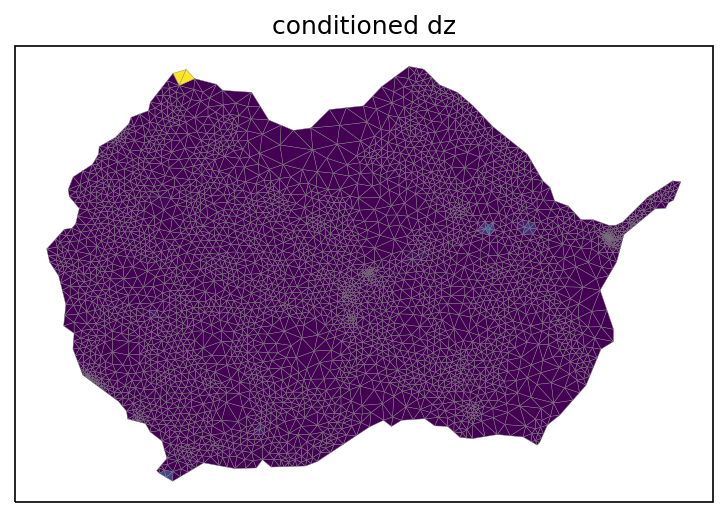

In [30]:
# hydrologically condition the mesh
workflow.condition.condition(m2)

# plot the change between the two meshes
diff = np.copy(mesh_points3)
diff[:,2] = m2.points[:,2] - mesh_points3[:,2] 
print("max diff = ", np.abs(diff[:,2]).max())
fig, ax = workflow.plot.get_ax(crs, figsize=figsize)
workflow.plot.triangulation(diff, m2.conn, crs, color='elevation', edgecolors='gray', 
                            linewidth=0.2, ax=ax)
ax.set_title('conditioned dz')
plt.show()

### Export surface mesh

In [31]:
m2.write_VTK(fname_surface_mesh)

## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

In [5]:
# m2 = workflow.mesh.Mesh2D.read_VTK(fname_surface_mesh)

In [32]:
# download the NLCD raster
lc_profile, lc_raster = workflow.get_raster_on_shape(sources['land cover'], 
                                                     watershed.exterior(), crs,
                                                     raster_crs=crs, 
                                                     mask=False, 
                                                     nodata=-1)

# resample the raster to the triangles
lc = workflow.values_from_raster(m2.centroids(), crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))


2020-11-09 17:00:21,109 - root - INFO: 
2020-11-09 17:00:21,110 - root - INFO: Preprocessing Raster
2020-11-09 17:00:21,111 - root - INFO: ------------------------------
2020-11-09 17:00:21,112 - root - INFO: collecting raster
2020-11-09 17:00:21,127 - root - INFO: CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["meters",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
2020-11-09 17:00:21,283 - root - INFO: Got raster of shape: (1, 245, 374)
2020-11-09 17:00:21,393 - root - INFO: Raster bounds: (3

In [33]:
# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                workflow.colors.generate_nlcd_colormap(lc)

# this is just hacking the label names to make them display a bit neater for a cleaner plot
nlcd_labels_fw = []
for label in nlcd_labels:
    label_fw = label
    if len(label) > 15:
        if ' ' in label:
            lsplit = label.split()
            if len(lsplit) == 2:
                label_fw = '\n'.join(lsplit)
            elif len(lsplit) == 4:
                label_fw = '\n'.join([' '.join(lsplit[0:2]),
                                      ' '.join(lsplit[2:])])
            elif len(lsplit) == 3:
                if len(lsplit[0]) > len(lsplit[-1]):
                    label_fw = '\n'.join([lsplit[0],
                                          ' '.join(lsplit[1:])])
                else:
                    label_fw = '\n'.join([' '.join(lsplit[:-1]),
                                          lsplit[-1]])
    nlcd_labels_fw.append(label_fw)

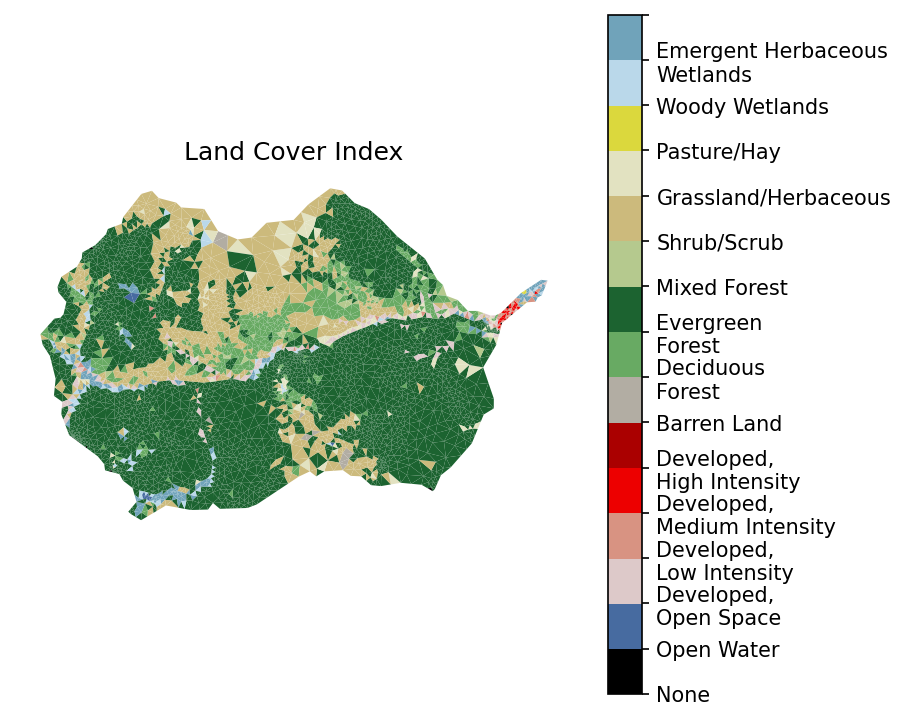

In [34]:
# plot the image
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

polys = workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)
mp = pcm.ScalarMappable(norm=nlcd_norm, cmap=nlcd_cmap)
cb = fig.colorbar(mp)
cb.set_ticks(nlcd_ticks)
cb.set_ticklabels(nlcd_labels_fw)
ax.set_title("Land Cover Index")
ax.axis('off')
# fig.tight_layout()
fig.savefig(fig_land_cover, dpi = 300, transparent = True)

## Subsurface properties

### Option 1 -- get soil structure from work flow (not working)

Need to fix the empty crs field in profile to use `workflow.get_shapes()`!

In [30]:
# # download the NRCS soils data as shapes and project it onto the mesh
# import workflow.sources.manager_nrcs
# import matplotlib.cm

# # -- download the shapes
# target_bounds = watershed.exterior().bounds

In [ ]:
# _, soil_survey = workflow.get_shapes(sources['soil type'], target_bounds, crs)

### Option 2 -- import soil data from SSURGO shp

In [ ]:
# _, soil_survey = workflow.get_shapes(fname_soil, target_bounds, crs) 

In [31]:
# with fiona.open(fname_soil, mode='r') as fid:
#     profile = fid.profile
#     soils = [r for (i,r) in fid.items()]

In [ ]:
# # if the profile['crs'] is empty, try manually assign CRS
# if not profile['crs']:
#     profile['crs'] = {'init': 'epsg:5070'}

# # convert to destination crs
# native_crs = workflow.crs.from_fiona(profile['crs'])
# if crs and not workflow.crs.equal(crs, native_crs):
#     for soil in soils:
#         workflow.warp.shape(soil, native_crs, crs)
# else:
#     crs = native_crs

In [ ]:
# soil_survey = [workflow.utils.shply(i) for i in soils]

**map MUKEY to meshes**

In [ ]:
# # -- log the bounds targetted and found
# logging.info('target bounds: {}'.format(target_bounds))
# logging.info('shape union bounds: {}'.format(
#     shapely.ops.cascaded_union(soil_survey).bounds))

In [108]:
# # -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
# #    properties
# soil_ids = np.array([shp.properties['MUKEY'] for shp in soil_survey], np.int32)

In [ ]:
# # -- color a raster by the polygons (this makes identifying a triangle's value much 
# #    more efficient)
# soil_color_raster, soil_color_profile, img_bounds = \
#             workflow.color_raster_from_shapes(target_bounds, target_dx=10, shapes=soil_survey,
#                                               shape_colors=soil_ids, shapes_crs = crs, nodata=-1)

# # -- resample the raster to the triangles
# soil_color = workflow.values_from_raster(m2.centroids(), crs, 
#                                          soil_color_raster, soil_color_profile)

### import soil map from gNATSGO raster

In [35]:
logging.info("import soil raster from {}".format(fname_soil))
with rasterio.open(fname_soil, 'r') as fid:
    soil_profile = fid.profile
    soil_raster = fid.read(1) # read the first band

2020-11-09 17:01:02,716 - root - INFO: import soil raster from /Users/shua784/OneDrive - PNNL/Projects/Exasheds/Upper_Colorado_River_Basin/GIS/gNATSGO/gNATSGO_CO_raster/MapunitRaster_10m1.tif


In [36]:
# resample the raster to the triangles
soil_color = workflow.values_from_raster(m2.centroids(), crs, soil_raster, soil_profile)

In [65]:
unique_soil_id = np.unique(soil_color)

In [37]:
logging.info(f'unique soil MUKEYs:\n {np.array(np.unique(soil_color, return_counts=True)).T}')

2020-11-09 17:01:38,133 - root - INFO: unique soil MUKEYs:
 [[498185     39]
 [498205     56]
 [498206    534]
 [498208      6]
 [498229    108]
 [498231    754]
 [509477    152]
 [509479     93]
 [509481    396]
 [509482    701]
 [509513    109]
 [509514    248]
 [509529     90]
 [509532   1627]
 [509547    268]
 [509548   1555]
 [509559     18]
 [509561     25]
 [509577      1]
 [509733     23]
 [509794     22]]


In [38]:
np.savetxt(fname_soil_id, np.array(np.unique(soil_color, return_counts=True)).T, 
           delimiter=' ', fmt = '%.0d')

### plot soil map

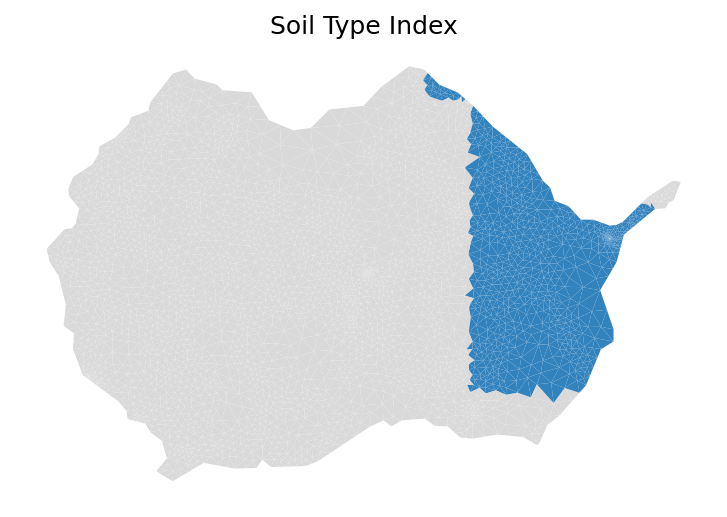

In [39]:
# plot the soil data
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0, color=soil_color, cmap='tab20c')
ax.set_title('Soil Type Index')
ax.axis('off')
# ax.legend()

fig.savefig(fig_soil_type, dpi = 300, transparent = True)

## get bedrock depth

Download global depth to bedrock at 250 m resolution from [soilgrids](http://globalchange.bnu.edu.cn/research/dtb.jsp).

In [40]:
with rasterio.open(fname_DTB, 'r') as fid:
    DTB_profile = fid.profile
    DTB_raster = fid.read(1) # read the first band
    logging.info("imported depth-to-bedrock from {}".format(fname_DTB))

2020-11-09 17:04:36,218 - root - INFO: imported depth-to-bedrock from /Users/shua784/OneDrive - PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/depth-to-bedrock/Global_absoluteDTB_M_250m_ll.tif


In [41]:
# resample the raster to the triangles
DTB_mesh = workflow.values_from_raster(m2.centroids(), crs, DTB_raster, DTB_profile)
DTB_mesh_meter = DTB_mesh/100 #convert from cm to m

In [42]:
logging.info(f'minimum depth-to-bedrock: {DTB_mesh.min()/100} m')
logging.info(f'maximum depth-to-bedrock: {DTB_mesh.max()/100} m')

2020-11-09 17:04:37,436 - root - INFO: minimum depth-to-bedrock: 3.35 m
2020-11-09 17:04:37,438 - root - INFO: maximum depth-to-bedrock: 26.39 m


### plot depth to bedrock

In [43]:
DTB_3d = workflow.elevate(mesh_points2, crs, DTB_raster/100, DTB_profile)

2020-11-09 17:07:34,450 - root - INFO: 
2020-11-09 17:07:34,487 - root - INFO: Elevating Triangulation to DEM
2020-11-09 17:07:34,495 - root - INFO: ------------------------------


(316690.15495, 329034.55405000004)
(4299344.330884162, 4307420.049100754)


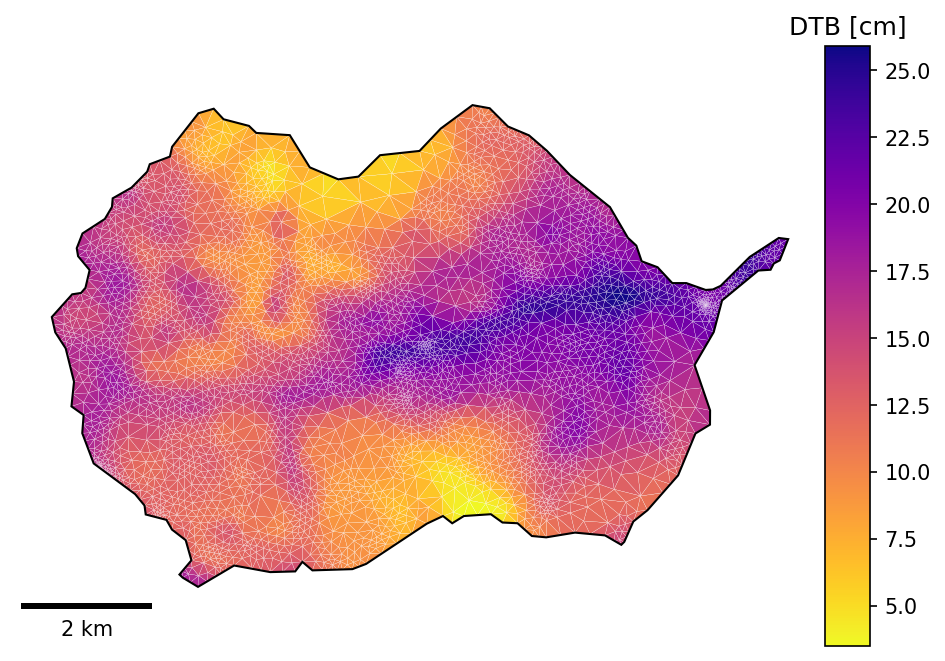

In [44]:
# plot the resulting surface mesh
fig = plt.figure(figsize=(6,5))
ax = workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
#ax2 = workflow.plot.get_ax(crs,fig, window=[0.65,0.05,0.3,0.5])
# ax2 = ax.inset_axes([0.58,0.45,0.3,0.3])
# cbax = fig.add_axes([0.05,0.05,0.9,0.05])
cbax = fig.add_axes([.95,0.1,0.05,0.8])

# bxlim = (591000., 600000.)
# bylim = (94000., 103000.)

mp = workflow.plot.triangulation(DTB_3d, mesh_tris, crs, ax=ax, 
                                 color='elevation', cmap = 'plasma_r', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
# workflow.plot.rivers(rivers, crs, ax=ax, color='aqua', linewidth=1)
ax.set_aspect('equal', 'datalim')
# ax.set_xlim([770000, 800000])
# ax.set_ylim([4520000, 4550000])

# mp2 = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
#                                  color='elevation', edgecolor='white', linewidth=0.5)
# workflow.plot.hucs(watershed, crs, ax=ax2, color='k', linewidth=1)
# workflow.plot.rivers(rivers, crs, ax=ax2, color='aqua', linewidth=1.5)
# ax2.set_xlim(bxlim)
# ax2.set_ylim(bylim)
# ax2.set_xticks([])
# ax2.set_yticks([])
# ax2.set_aspect('equal', 'datalim')

# ax.indicate_inset_zoom(ax2, edgecolor='r')

# ax.margins(0.5)
ax.axis('off')
# add scalebar, use 1 for UTM coordinates, the default unit is "m"
scalebar1 = ScaleBar(1, location = "lower left")
ax.add_artist(scalebar1)
# scalebar2 = ScaleBar(1, location = "upper right")

# ax2.add_artist(scalebar2)

print(ax.get_xlim())
print(ax.get_ylim())
cbar.ax.set_title('DTB [m]')

# fig.tight_layout()
fig.savefig(fig_DTB, dpi = 300, transparent = True)

## map geology

1. Manually download global geology map (GLHYMPS v2.0) from [here](https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP2/TTJNIU)
2. Extract the shapefile 
3. (optional) clip the global map to watershed shape. This will increase the processing speed.

In [51]:
with fiona.open(fname_geology, mode='r') as fid:
    profile = fid.profile
    geology = [r for (i,r) in fid.items()]

In [52]:
# if the profile['crs'] is empty, try manually assign CRS
if not profile['crs']:
    raise ValueError('CRS is not found! Try manually assign one.')
    profile['crs'] = {'init': 'epsg:5070'}

# convert to destination crs
native_crs = workflow.crs.from_fiona(profile['crs'])
if crs and not workflow.crs.equal(crs, native_crs):
    for geol in geology:
        workflow.warp.shape(geol, native_crs, crs)
else:
    crs = native_crs

In [53]:
geol_survey = [workflow.utils.shply(i) for i in geology]

**map geology id to meshes**

In [54]:
target_bounds = watershed.exterior().bounds
shape_union_bounds = shapely.ops.cascaded_union(geol_survey).bounds

In [55]:
# -- log the bounds targetted and found
logging.info(f'target bounds: {target_bounds}')
logging.info(f'shape union bounds: {shape_union_bounds}')
if target_bounds[0] < shape_union_bounds[0] or target_bounds[1] < shape_union_bounds[1] or target_bounds[2] > shape_union_bounds[2] or target_bounds[3] > shape_union_bounds[3]:
    raise RuntimeError('target watershed falls outside the shape union bound!')

2020-11-09 17:21:38,989 - root - INFO: target bounds: (317251.2640131897, 4299711.408984916, 328473.4449929282, 4307052.970983125)
2020-11-09 17:21:38,989 - root - INFO: shape union bounds: (258377.318218577, 4249336.324722821, 401404.3881361255, 4356761.065907117)


In [56]:
# -- determine the geology id for each polygon
geol_ids = np.array([shp.properties['OBJECTID_1'] for shp in geol_survey], np.int32)

In [57]:
# convert shapefile to raster using geology ids
geol_color_raster, geol_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, target_dx=10, shapes=geol_survey,
                                              shape_colors=geol_ids, shapes_crs = crs, nodata=-9999)

2020-11-09 17:21:48,064 - root - INFO: Coloring shapes onto raster:
2020-11-09 17:21:48,065 - root - INFO:   target_bounds = (317251.2640131897, 4299711.408984916, 328473.4449929282, 4307052.970983125)
2020-11-09 17:21:48,065 - root - INFO:   out_bounds = [317246.0, 4299708.0, 328486.0, 4307058.0]
2020-11-09 17:21:48,066 - root - INFO:   pixel_size = 10
2020-11-09 17:21:48,066 - root - INFO:   width = 1124, height = 735
2020-11-09 17:21:48,067 - root - INFO:   and 528 independent colors of dtype int32


In [58]:
# -- resample the raster to the triangles
geol_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         geol_color_raster, geol_color_profile)

In [59]:
unique_geol_id = np.unique(geol_color)
logging.info(f'unique geology ids: {np.array(np.unique(geol_color, return_counts=True)).T}')

2020-11-09 17:21:52,640 - root - INFO: unique geology ids: [[715639    736]
 [715766     45]
 [715779    588]
 [715796      5]
 [726604   1449]
 [726608    876]
 [726639   2402]
 [726642    105]
 [726664     93]
 [726667     19]
 [730801    507]]


In [60]:
np.savetxt(fname_geol_id, np.array(np.unique(geol_color, return_counts=True)).T, 
           delimiter=' ', fmt = '%.0d')

In [76]:
# with open(fname_geol_id, 'w') as f:
#     for item in unique_geol_id:
#         f.write("%s\n" % item)

### plot geology map

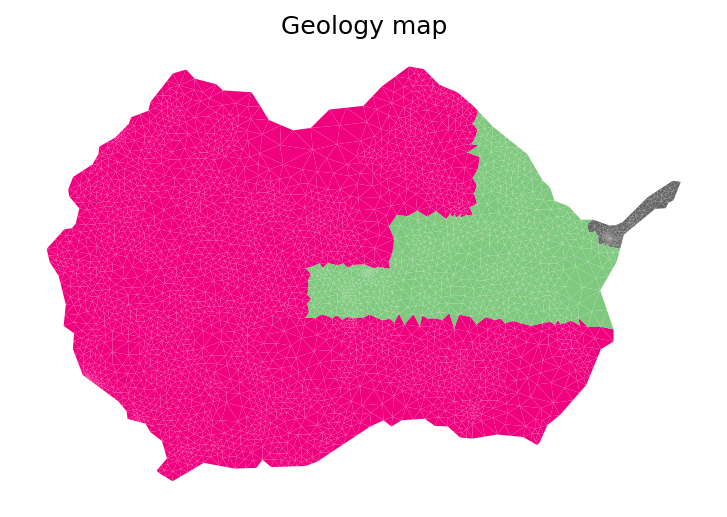

In [61]:
# plot the soil data
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0, color=geol_color, cmap='Accent')
ax.set_title('Geology map')
ax.axis('off')
# ax.legend()

fig.savefig(fig_geol_map, dpi = 300, transparent = True)

## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

In [62]:
total_tckness = np.ceil(DTB_mesh_meter.max())
logging.info(f'total thickness: {total_tckness} m')

2020-11-09 17:23:24,902 - root - INFO: total thickness: 27.0 m


In [63]:
ele_per_layer = mesh_tris.shape[0]

In [66]:
if doArraysIntersect(unique_geol_id, unique_soil_id) or doArraysIntersect(unique_geol_id, [999]) or doArraysIntersect(unique_soil_id, [999]):
    raise RuntimeWarning('Common id is found in either soil/geol/bedrock!')

In [67]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []
z_top = []

z = 0.0
z_top.append(z)
# -- soil layer --
#  top 6 m
#  5 cm initial top cell
#  10 cells
#  expanding dz, growing with depth
ncells = 10
dz = 0.05
layer_dz = 2 # total top thickness

tele = workflow.mesh.telescope_factor(ncells, dz, layer_dz)
logging.info("Got telescoping factor: {}".format(tele))
for i in range(ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(soil_color)
    z += dz
#     dz *= tele
    dz = round(dz * tele, 2)
    z_top.append(z)    

# -- geologic layer --
# keep going for 2m cells until we hit the bottom of
# the domain
dz = 2.0

geo_ncells = int(np.ceil((total_tckness-z)/dz))
for i in range(geo_ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
#     ilayer_id = 900 + ncells + i + 1
#     layer_mat_ids.append(ilayer_id * np.ones_like(soil_color))
    layer_mat_ids.append(geol_color)
    z += dz    
    z_top.append(z)

2020-11-09 17:24:53,870 - root - INFO: Converged?: ratio = 1.287216430179099, layer z (target = 2) = -1.2583267761101524e-11
2020-11-09 17:24:53,871 - root - INFO: Got telescoping factor: 1.287216430179099


In [68]:
# print the summary
workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2020-11-09 17:24:58,921 - root - INFO: Cell summary:
2020-11-09 17:24:58,922 - root - INFO: ------------------------------------------------------------
2020-11-09 17:24:58,923 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2020-11-09 17:24:58,923 - root - INFO: ------------------------------------------------------------
2020-11-09 17:24:58,924 - root - INFO:  00 	| 00 	| 509532 	|   0.050000 	|   0.000000
2020-11-09 17:24:58,924 - root - INFO:  01 	| 01 	| 509532 	|   0.060000 	|   0.050000
2020-11-09 17:24:58,925 - root - INFO:  02 	| 02 	| 509532 	|   0.080000 	|   0.110000
2020-11-09 17:24:58,925 - root - INFO:  03 	| 03 	| 509532 	|   0.100000 	|   0.190000
2020-11-09 17:24:58,926 - root - INFO:  04 	| 04 	| 509532 	|   0.130000 	|   0.290000
2020-11-09 17:24:58,926 - root - INFO:  05 	| 05 	| 509532 	|   0.170000 	|   0.420000
2020-11-09 17:24:58,927 - root - INFO:  06 	| 06 	| 509532 	|   0.220000 	|   0.590000
2020-11-09 17:24:58,927 - root - INFO:  07 	| 07 	| 509532 	|   0

### add bedrock material

In [69]:
# get depth below top cell face
z_top = np.asarray(z_top)
z_center = z_top[:-1] + (z_top[1:]-z_top[:-1])/2

In [70]:
mat_ids = np.stack(layer_mat_ids)

for icol in np.arange(mat_ids.shape[1])[:]:
#     idem = DEM_mesh[icol]
    idtb = DTB_mesh_meter[icol]
#     ielev = idem - z_center
    idx = z_center > idtb
    
    # assign 999 to bedrock
    mat_ids[idx, icol] = 999

In [71]:
layer_mat_ids = [mat_ids[row, :] for row in np.arange(mat_ids.shape[0])]

### extrusion

In [72]:
# extrude
m3 = workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

### add sidesets from land cover type

In [73]:
# add back on land cover side sets
surf_ss = m3.side_sets[1]

for index, name in zip(nlcd_indices, nlcd_labels):
    where = np.where(lc == index)[0]
    ss = workflow.mesh.SideSet(name, int(index), 
                            [surf_ss.elem_list[w] for w in where],
                            [surf_ss.side_list[w] for w in where])        
    m3.side_sets.append(ss)

In [74]:
# save to disk
try:
    os.remove(fname_final_mesh)
except FileNotFoundError:
    pass
m3.write_exodus(fname_final_mesh)


You are using exodus.py v 1.19.1 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: ./meshes/CoalCreek_final_mesh.exo
Closing exodus file: ./meshes/CoalCreek_final_mesh.exo
